# June 07, 2021

**Motivation**: Spatially homogenous parcellation **(fMRI)**.  Functional connectivity, community structure </br>

In [1]:
# HIDE CODE


import os
import ants
import nrrd

import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import networkx as nx
import operator as op
from copy import deepcopy as dc
from os.path import join as pjoin

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from utils.processing import *
from utils.network import *
from utils.plotting import *

# Allen
allen_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/allen')
allen_path = pjoin(allen_ws, 'MouseConnectivity')
os.makedirs(allen_path, exist_ok=True)
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def trim_axs(axes, n):
    axs = axes.flat
    for ax in axs[n:]:
        ax.remove()
    return axs[:n]


def add_children(graph: nx.DiGraph(), src_id: int, level: int, mcc: MouseConnectivityCache = None):
    mcc = MouseConnectivityCache(resolution=100) if mcc is None else mcc
    structure_tree = mcc.get_structure_tree()
    
    src = structure_tree.get_structures_by_id([src_id])[0]
    children = structure_tree.children([src_id])[0]
    for child in children:
        src_name = '\n'.join(src['name'].split(' '))
        tgt_name = '\n'.join(child['name'].split(' '))
        graph.add_node(tgt_name, lvl=level)
        graph.add_edge(src_name, tgt_name)
    return graph, children


def make_tree_graph(root: str, n_levels: int = 3, mcc: MouseConnectivityCache = None):
    mcc = MouseConnectivityCache(resolution=100) if mcc is None else mcc
    structure_tree = mcc.get_structure_tree()
    structure = structure_tree.get_structures_by_name([root])[0]
    
    g = nx.DiGraph()
    g.add_node('\n'.join(structure['name'].split(' ')), lvl=0)

    dend = {}
    for lvl in range(n_levels):
        if lvl == 0:
            src_ids = [structure['id']]
        else:
            new_leaves = []
            for i in src_ids:
                g, children = add_children(graph=g, src_id=i, level=lvl)
                for child in children:
                    new_leaves.append(child['id'])
            src_ids = new_leaves
        dend[lvl] = src_ids
 
    return g, dend


def reorient_arr(x: np.ndarray, tr_axes: Tuple = (2, 1, 0)):
    if len(x.shape) == 4:
        tr_axes += (3,)
    return np.transpose(x, tr_axes)[::-1]


def mask_left_right(mask: np.ndarray, left_right_axis: int = 2):
    npix = mask.shape[left_right_axis]
    coverage = int(np.ceil(npix/2))
    slices_l = tuple(
        slice(0, coverage) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    slices_r = tuple(
        slice(npix-coverage, npix) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    mask_l = mask.copy().astype(bool)
    mask_r = mask.copy().astype(bool)
    mask_l[slices_r] = 0
    mask_r[slices_l] = 0
    
    return mask_l.astype(bool), mask_r.astype(bool)


from time import time
from sklearn.cluster import KMeans
import sklearnex


def kmeans_parcellation(
    mask: np.ndarray,
    num_regions: int = 256,
    symmetrize: bool = False,
    left_right_axis: int = 2,
    random_state: int = 42, ):
    
    sklearnex.patch_sklearn()
    mask_l, mask_r = mask_left_right(mask, left_right_axis)
    
    if symmetrize:
        mask_r_full = mask_r.copy()
        mask_l_full = mask_l.copy()
        mask_r_full[slices_l] = np.flip(mask_r[slices_r], axis=left_right_axis)
        mask_l_full[slices_r] = np.flip(mask_l[slices_l], axis=left_right_axis)
        mask_sym = np.logical_and(mask_r_full, mask_l_full)
        
        mask_l = mask_sym.copy().astype(bool)
        mask_r = mask_sym.copy().astype(bool)
        mask_l[slices_r] = 0
        mask_r[slices_l] = 0
        
        # do left
        atlas_kmeans, cluster_centers = _do_kmeans(mask_l, num_regions, random_state)
        
        # mirror symmetry clusters to right hemisphere
        for region_id in np.unique(atlas_kmeans[atlas_kmeans > 0]):
            
            region_id_r = region_id + num_regions
            flipped = np.flip(atlas_kmeans[slices_l], axis=left_right_axis)
            atlas_kmeans[slices_r][flipped == region_id] = region_id_r
            
            # get center for right cluster
            _ctr = cluster_centers[region_id].copy()
            delta = npix/2 - _ctr[left_right_axis]
            _ctr[left_right_axis] += 2*delta - 1
            cluster_centers[region_id_r] = _ctr

    else:
        atlas_kmeans_l, cluster_centers_l = _do_kmeans(mask_l, num_regions, random_state)
        atlas_kmeans_r, cluster_centers_r = _do_kmeans(mask_r, num_regions, random_state)
        
        atlas_kmeans_r += num_regions 
        cluster_centers_r = {i+num_regions: ctr for i, ctr in cluster_centers_r.items()}
        
        atlas_kmeans = atlas_kmeans_l.copy()
        atlas_kmeans[mask_r] = atlas_kmeans_r[mask_r]
        cluster_centers = {**cluster_centers_l, **cluster_centers_r}

    sklearnex.unpatch_sklearn()
    output = {
        'atlas_kmeans': atlas_kmeans.astype(int),
        'cluster_centers': cluster_centers,
        'mask_l': mask_l.astype(bool),
        'mask_r': mask_r.astype(bool),
    }
    return output


def _do_kmeans(x, num_regions, random_state):
    nonzero_voxels = list(zip(*np.where(x.astype(bool))))
    nonzero_voxels = np.reshape(nonzero_voxels, (-1, len(x.shape)))
    nonzero_voxels = nonzero_voxels.astype(int)

    kmeans = KMeans(
        n_clusters=num_regions,
        random_state=random_state,
    ).fit(nonzero_voxels.astype(float))
    roi = kmeans.predict(nonzero_voxels.astype(float))

    roi_unique = []
    for lbl in roi:
        if lbl not in roi_unique:
            roi_unique.append(lbl)
    mapping = {lbl: i+1 for i, lbl in enumerate(roi_unique)}

    roi_relabeld = np.zeros_like(roi)
    for lbl in roi_unique:
        roi_relabeld[roi == lbl] = mapping[lbl]

    atlas_kmeans_dict = defaultdict(list)
    for voxel, lbl in zip(nonzero_voxels, roi_relabeld):
        atlas_kmeans_dict[lbl].append(tuple(voxel))
    atlas_kmeans_dict = dict(atlas_kmeans_dict)

    atlas_kmeans = np.zeros(x.shape, dtype=int)
    for region_id, voxel_list in atlas_kmeans_dict.items():
        atlas_kmeans[tuple(zip(*voxel_list))] = region_id

    cluster_centers = {mapping[lbl]: kmeans.cluster_centers_[lbl] for lbl in roi_unique}
    
    return atlas_kmeans, cluster_centers


def translate_labels(labels: List[str], mcc: MouseConnectivityCache = None):
    mcc = MouseConnectivityCache(resolution=100) if mcc is None else mcc
    structure_tree = mcc.get_structure_tree()
    
    left_right = []
    structure_ids = []
    region_ids = []
    for label in labels:
        try:
            lr, structure_id, region_id = tuple(map(lambda x: int(x), label.split('-')))
        except ValueError:
            lr, structure_id = tuple(map(lambda x: int(x), label.split('-')))
            region_id = None
        left_right.append('L' if lr == 0 else 'R')
        structure_ids.append(structure_id)
        region_ids.append(region_id)
        
    structures = structure_tree.get_structures_by_id(structure_ids)
    translated = [
        '{:s}-{:s}'.format(lr, struct['name']) if region_id is None else
        '{:s}-{:s}-{:d}'.format(lr, struct['name'], region_id)
        for lr, struct, region_id in zip(left_right, structures, region_ids)
    ]
    return translated


def plot_parcellation(
    parcellation: np.ndarray,
    mask_l: np.ndarray,
    mask_r: np.ndarray,
    root_mask: np.ndarray,
    figsize=(9, 7),
    cmap='turbo', ):

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    for i in range(2):
        for j in range(3):
            x = parcellation.copy()

            if i == 0:
                x[mask_r] = 0
                label = 'left\n'
            else:
                x[mask_l] = 0
                # x[x != 0] -= int(np.max(parcellation) // 2)
                label = 'right\n'

            if j == 0:
                title = 'coronal'
            elif j == 1:
                title = 'axial'
            else:
                title = 'saggital'

            data2plt = np.ma.masked_where(~root_mask.astype(bool), x)
            axes[i, j].imshow(data2plt.mean(j), cmap=cmap)

            list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(title, fontsize=17, y=1.2)
            else:
                axes[i, j].set_title('')
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=17)

    fig.tight_layout()
    plt.show()
    
    return fig, axes


def plot_registration(
    fixed: np.ndarray,
    moving: np.ndarray,
    warped: np.ndarray,
    figsize=(6, 8), ):
    
    sns.set_style('white')
    fig, axes = plt.subplots(3, 3, figsize=figsize)

    for i in range(3):
        for j in range(3):       
            if i == 0:
                x = fixed.numpy()
                label = 'fixed'
            elif i == 1:
                x = moving.numpy()
                label = 'moving'
            else:
                x = warped.numpy()
                label = 'warped'

            if i == 0:
                if j == 0:
                    top_title = 'axis = {:d}\n(coronal)'.format(j)
                elif j == 1:
                    top_title = 'axis = {:d}\n(axial)'.format(j)
                else:
                    top_title = 'axis = {:d}\n(saggital)'.format(j)
                axes[i, j].set_title(top_title, y=1.1, fontsize=13)

            if j == 0:
                axes[i, j].set_ylabel(label + '\n', fontsize=13)

            data2plt = x.mean(j)
            axes[i, j].imshow(data2plt)

            _ = list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    msg = 'Plotting averaged data across different dimensions\n\n'
    msg += '1st row (fixed):  Average template,    shape = {}\n'.format(fixed.shape)
    msg += '2nd row (moving):  Anatomical data,    shape = {}\n'.format(moving.shape)
    msg += '3rd row (warped):  Anatomical data,    shape = {}'.format(warped.shape)
    plt.suptitle(msg, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig, axes





In [3]:
import allensdk
print(allensdk.__version__)

2.11.2


## Load Allen data

In [4]:
manifest_file = pjoin(allen_ws, 'MouseConnectivity', 'manifest.json')
mcc = MouseConnectivityCache(resolution=100, manifest_file=manifest_file)
structure_tree = mcc.get_structure_tree()

root = structure_tree.get_structures_by_name(['root'])[0]
cerebrum = structure_tree.get_structures_by_name(['Cerebrum'])[0]
isocortex = structure_tree.get_structures_by_name(['Isocortex'])[0]

template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

root_mask, root_mask_info = mcc.get_structure_mask(root['id'])
cerebrum_mask, cerebrum_mask_info = mcc.get_structure_mask(cerebrum['id'])
cortex_mask, cortex_mask_info = mcc.get_structure_mask(isocortex['id'])

In [5]:
from prettytable import PrettyTable
table = PrettyTable(field_names=['lvl', 'name', '# voxels', 'relative sz'])

_, dend = make_tree_graph(root='Cerebrum', n_levels=4)
m0 = mcc.get_structure_mask(cerebrum['id'])[0]

names = collections.defaultdict(list)
for lvl, struct_ids in dend.items():
    for struct_id in struct_ids:
        name = structure_tree.get_structures_by_id([struct_id])[0]['name']
        if name == 'Layer 6b, isocortex':
            continue
        names[lvl].append(name)
        m1 = mcc.get_structure_mask(struct_id)[0]
        
        table.add_row([lvl, name, m1.sum(), '{:.1f} {:s}'.format(m1.sum() / m0.sum() * 100, '%')])
        
    if lvl < len(dend) - 1:
        table.add_row([''] * len(table.field_names))

names = dict(names)
print(table)

+-----+--------------------------------+----------+-------------+
| lvl |              name              | # voxels | relative sz |
+-----+--------------------------------+----------+-------------+
|  0  |            Cerebrum            |  275611  |   100.0 %   |
|     |                                |          |             |
|  1  |        Cerebral cortex         |  221252  |    80.3 %   |
|  1  |        Cerebral nuclei         |  54359   |    19.7 %   |
|     |                                |          |             |
|  2  |         Cortical plate         |  212402  |    77.1 %   |
|  2  |       Cortical subplate        |   8850   |    3.2 %    |
|  2  |            Striatum            |  45063   |    16.4 %   |
|  2  |            Pallidum            |   9296   |    3.4 %    |
|     |                                |          |             |
|  3  |           Isocortex            |  123245  |    44.7 %   |
|  3  |        Olfactory areas         |  46478   |    16.9 %   |
|  3  |   

## ROI definition (CCF space)

In [6]:
num_regions = 8

parcellation = kmeans_parcellation(
    mask=cortex_mask,
    num_regions=num_regions,
    symmetrize=False,
    left_right_axis=2,
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


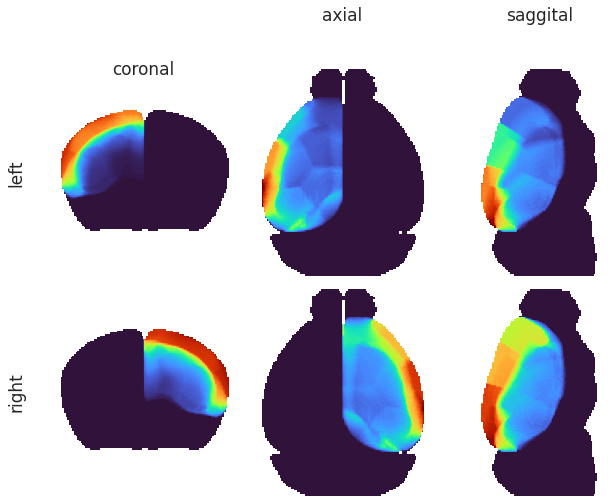

In [7]:
_ = plot_parcellation(
    parcellation=parcellation['atlas_kmeans'],
    mask_l=parcellation['mask_l'],
    mask_r=parcellation['mask_r'],
    root_mask=root_mask,
)

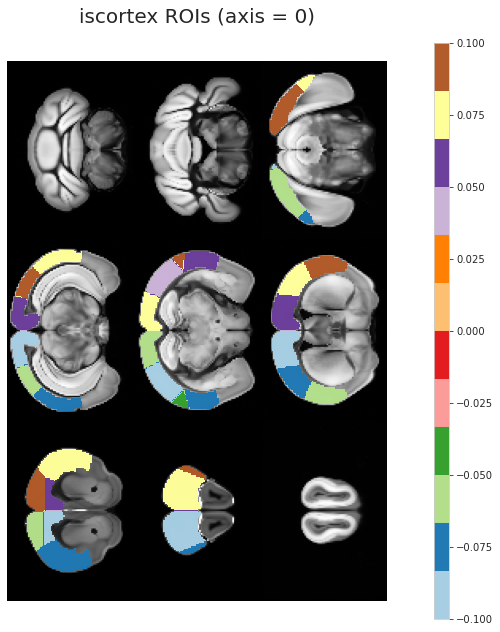

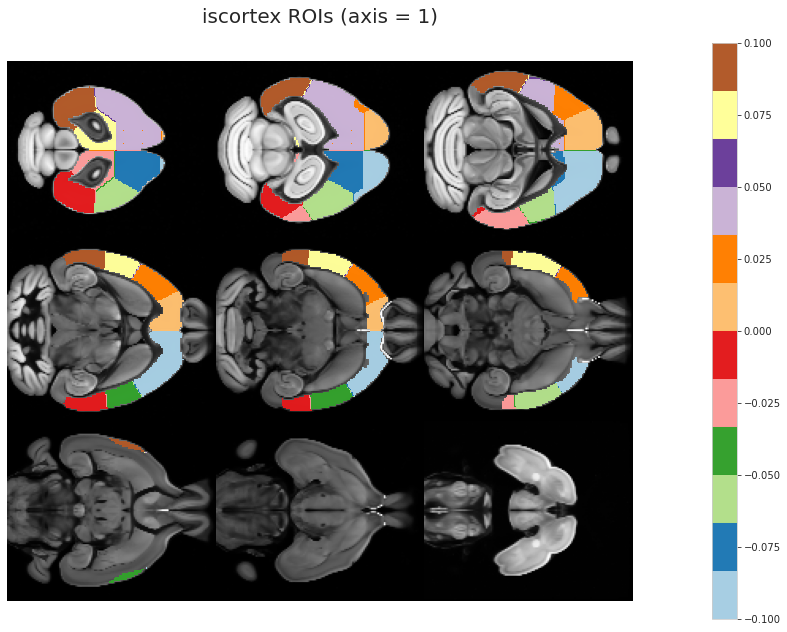

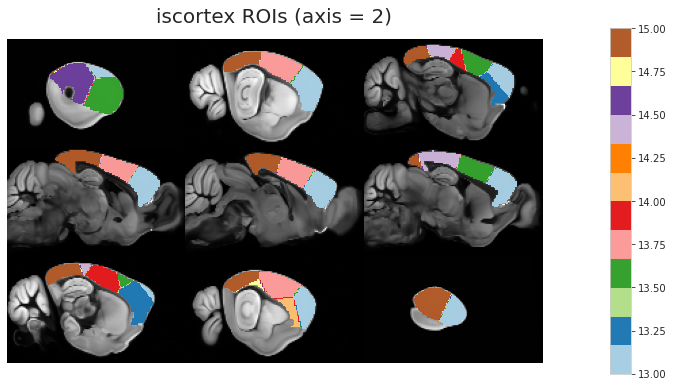

In [8]:
x = parcellation['atlas_kmeans'].copy().astype(float)
x[x == 0] = np.nan

for axis in range(3):
    ants.from_numpy(template.astype(float)).plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='Paired',
        overlay_alpha=0.99,
        axis=axis,
        nslices=9,
        title='iscortex ROIs (axis = {:d})'.format(axis),
        figsize=1.5 if axis == 2 else 2.5,
        cbar=True,
        cbar_dx=0.07,
    )

In [9]:
#x = parcellation['atlas_kmeans'].copy().astype(float)
atlas_kmeans_eroded = np.zeros_like(parcellation['atlas_kmeans'])

radius = 6
accepted = 0
rejected = 0
for region_id, ctr in tqdm(parcellation['cluster_centers'].items(), leave=False):
    for voxel in list(zip(*np.where(parcellation['atlas_kmeans'] == region_id))):
        dist = np.linalg.norm(ctr - voxel)
        if dist < radius:
            atlas_kmeans_eroded[voxel] = region_id
            accepted += 1
        else:
            rejected += 1
            
accepted, rejected

  0%|          | 0/16 [00:00<?, ?it/s]

(13562, 109683)

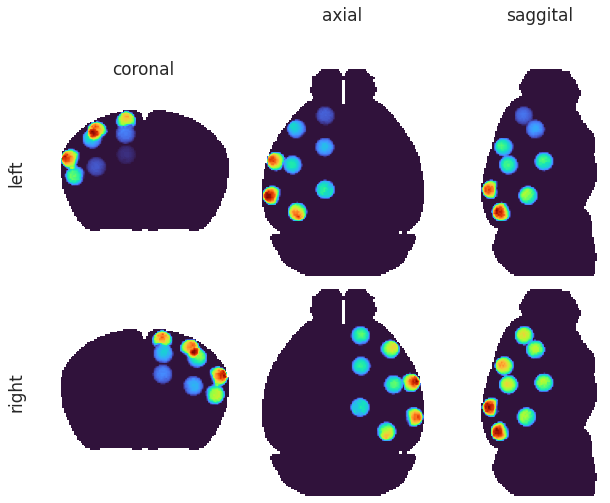

In [10]:
_ = plot_parcellation(
    parcellation=atlas_kmeans_eroded,
    mask_l=parcellation['mask_l'],
    mask_r=parcellation['mask_r'],
    root_mask=root_mask,
)

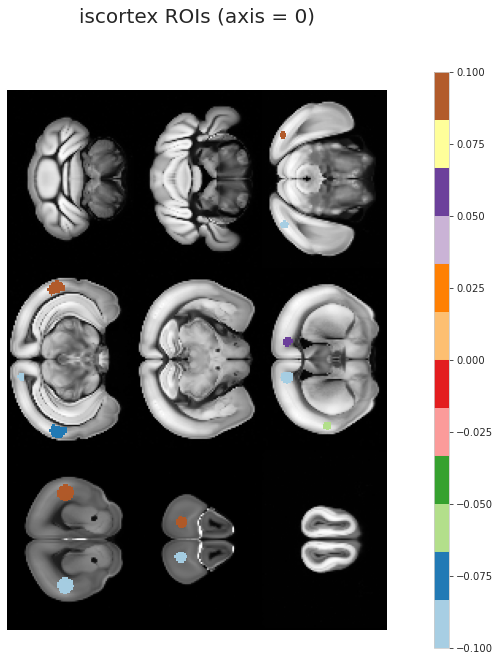

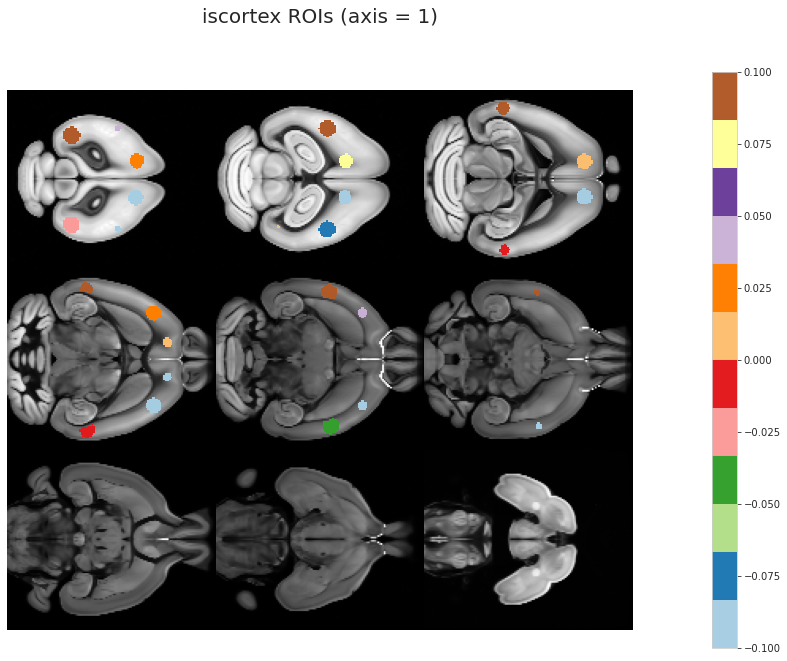

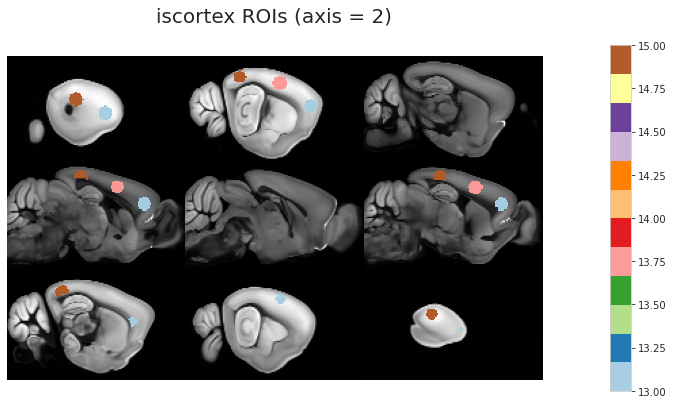

In [11]:
x = atlas_kmeans_eroded.copy().astype(float)
x[x == 0] = np.nan

for axis in range(3):
    ants.from_numpy(template.astype(float)).plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='Paired',
        overlay_alpha=0.99,
        axis=axis,
        nslices=9,
        figsize=1.5 if axis == 2 else 2.5,
        title='iscortex ROIs (axis = {:d})'.format(axis),
        title_dy=0.04,
        cbar=True,
        cbar_dx=0.07,
    )

<AxesSubplot:ylabel='Count'>

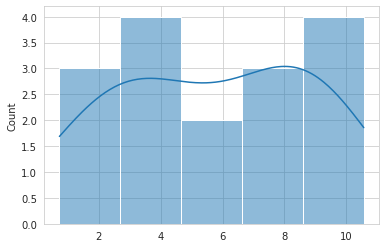

In [12]:
x = atlas_kmeans_eroded.copy().astype(float)
vals = []
for region_id in np.unique(x[x > 0]):
    vals.append(x[x == region_id].sum() / cortex_mask.sum() * 100)

sns.histplot(vals, kde=True)

In [13]:
np.min(vals), np.max(vals)

(0.7229502211043045, 10.567568664043165)

## Define ROIs

In [14]:
selected_names = [
    'Striatum',
    'Pallidum',
    'Olfactory areas',
    'Cortical subplate',
    'Hippocampal formation',
    'Isocortex',
]
selected_names

['Striatum',
 'Pallidum',
 'Olfactory areas',
 'Cortical subplate',
 'Hippocampal formation',
 'Isocortex']

In [15]:
root_mask_l, root_mask_r = mask_left_right(root_mask)
selected_structures = structure_tree.get_structures_by_name(selected_names)

roi_masks = {}
for structure_dict in selected_structures:
    print('id: {:d},\tname: {:s}'.format(structure_dict['id'], structure_dict['name']))
    if structure_dict['name'] == 'Isocortex':
        for region_id_l in range(1, num_regions+1):
            region_id_r = region_id_l + num_regions
            _mask_l = atlas_kmeans_eroded == region_id_l
            _mask_r = atlas_kmeans_eroded == region_id_r
            roi_masks['0-{:d}-{:d}'.format(structure_dict['id'], region_id_l)] = _mask_l.astype(bool)
            roi_masks['1-{:d}-{:d}'.format(structure_dict['id'], region_id_r)] = _mask_r.astype(bool)
    else:
        _mask = mcc.get_structure_mask(structure_dict['id'])[0]
        _mask_l = np.logical_and(_mask, root_mask_l)
        _mask_r = np.logical_and(_mask, root_mask_r)
        roi_masks['0-{:d}'.format(structure_dict['id'])] = _mask_l.astype(bool)
        roi_masks['1-{:d}'.format(structure_dict['id'])] = _mask_r.astype(bool)

id: 477,	name: Striatum
id: 803,	name: Pallidum
id: 698,	name: Olfactory areas
id: 703,	name: Cortical subplate
id: 1089,	name: Hippocampal formation
id: 315,	name: Isocortex


In [16]:
roi_masks.keys()

dict_keys(['0-477', '1-477', '0-803', '1-803', '0-698', '1-698', '0-703', '1-703', '0-1089', '1-1089', '0-315-1', '1-315-9', '0-315-2', '1-315-10', '0-315-3', '1-315-11', '0-315-4', '1-315-12', '0-315-5', '1-315-13', '0-315-6', '1-315-14', '0-315-7', '1-315-15', '0-315-8', '1-315-16'])

## Register using ANTs

### Load anat + func data

In [17]:
config = Config()

func = {}
for key, (subject, session, run) in tqdm(config.looper.items()):
    if subject != 6 or session != 1:
        continue

    keywords = key.split('_')[:2] + ['space-individual']

    # func
    kws_func = keywords + ['run-{:d}'.format(run), 'bold']
    gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_func))
    try:
        func_file = pjoin(config.raw_dir, next(gen))
    except StopIteration:
        continue
    x = nib.load(func_file).get_fdata()
    func[key] = reorient_arr(x)
    
    # since we don't need to loop over runs for this
    if run != 1:
        continue

    # anat
    kws_anat = keywords + ['T1w']
    gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_anat))
    anat_file = pjoin(config.raw_dir, next(gen))

    # mask
    kws_mask = keywords + ['desc-mask', 'bold']
    gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_mask))
    mask_file = pjoin(config.raw_dir, next(gen))

    # load anat and mask and reorient
    moving = nib.load(anat_file).get_fdata()
    mask = nib.load(mask_file).get_fdata()
    moving *= mask

    moving = reorient_arr(moving)
    moving_mask = ants.from_numpy(moving).get_mask().numpy()

moving, moving_mask, fixed = [
    ants.from_numpy(arr.astype(float), origin=[0]*3, spacing=[1.0]*3)
    for arr in [moving, moving_mask, template]
]

  0%|          | 0/210 [00:00<?, ?it/s]

In [18]:
moving.shape, moving_mask.shape, func[config.get_key(6, 1, 1)].shape, fixed.shape

((78, 64, 64), (78, 64, 64), (78, 64, 64, 600), (132, 80, 114))

### Register

In [19]:
n_seeds = 10
seeds = [2**i for i in range(n_seeds)]

# dict_list = []
transforms = []
performances = []
for seed in seeds:
    tx = ants.registration(
        fixed=fixed,
        moving=moving,
        mask=moving_mask,
        type_of_transform='SyN',
        verbose=True,
        random_seed=42,
    )
    warped = ants.apply_transforms(
        fixed=fixed,
        moving=moving,
        transformlist=tx['fwdtransforms'],
        interpolator='linear',
    )
    
    # transforms[seed] = tx
    
    mi = ants.image_mutual_information(fixed, warped)
    mi_base = ants.image_mutual_information(fixed, fixed)
    
    transforms.append(tx)
    performances.append(mi/mi_base)
    # rel_mi = 
    
    # data_dict = {
    #     'seed': [seed],
    #     'mi': [mi],
    #     'mi_base': [mi_base],
    #     'rel_mi': [rel_mi],
   #  }
   #  dict_list.append(data_dict)
    
# df = pd.DataFrame(merge_dicts(dict_list))
best_tx = transforms[np.argmax(performances)]

In [20]:
warped = ants.apply_transforms(
    fixed=fixed,
    moving=moving,
    transformlist=best_tx['fwdtransforms'],
    interpolator='linear',
)
warped

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (132, 80, 114)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [21]:
mi = ants.image_mutual_information(fixed, warped)
mi_base = ants.image_mutual_information(fixed, fixed)
mi/mi_base

0.45025510425814297

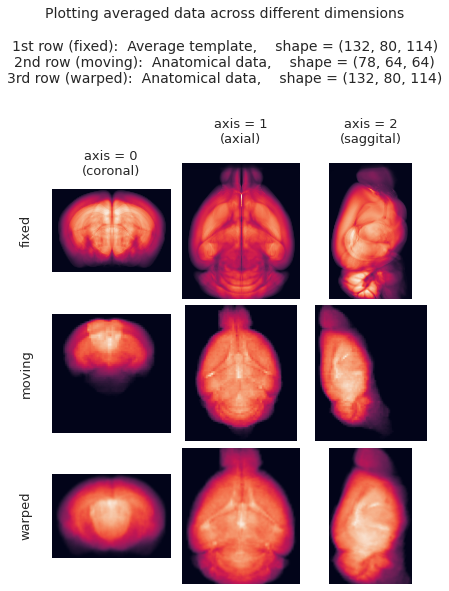

In [22]:
_ = plot_registration(fixed, moving, warped)

### Inv mask transforms

In [23]:
roi_masks_inv = {
    lbl: ants.apply_transforms(
        fixed=moving,
        moving=ants.from_numpy(mask.astype(float), origin=[0]*3, spacing=[1.0]*3),
        transformlist=best_tx['invtransforms'],
        interpolator='genericLabel',
    )
    for lbl, mask in roi_masks.items()
}
mask_l_inv, mask_r_inv, root_mask_inv, cerebrum_mask_inv = [
    ants.apply_transforms(
        fixed=moving,
        moving=ants.from_numpy(mask.astype(float), origin=[0]*3, spacing=[1.0]*3),
        transformlist=best_tx['invtransforms'],
        interpolator='genericLabel',)
    for mask in [parcellation['mask_l'], parcellation['mask_r'], root_mask, cerebrum_mask]
]

In [24]:
atlas_kmeans_inv = np.zeros(moving.shape)
for key, mask_inv in roi_masks_inv.items():
    if str(isocortex['id']) not in key:
        continue
    region_id = key.split('-')[-1]
    atlas_kmeans_inv[mask_inv.numpy().astype(bool)] = region_id

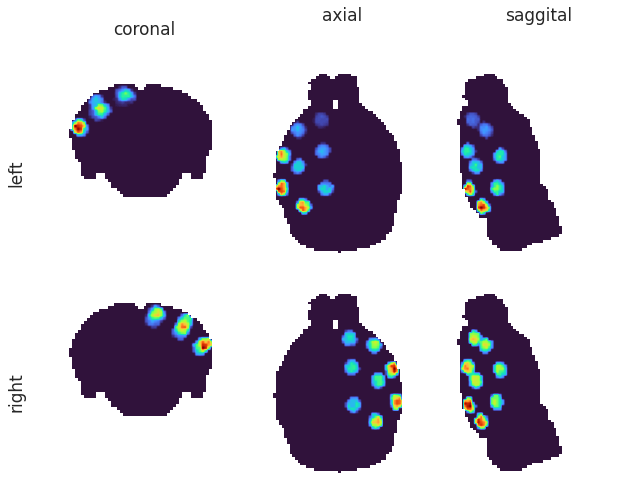

In [25]:
_ = plot_parcellation(
    parcellation=atlas_kmeans_inv,
    mask_l=mask_l_inv.numpy().astype(bool),
    mask_r=mask_r_inv.numpy().astype(bool),
    root_mask=root_mask_inv.numpy().astype(bool),
)

### Combine functional data

In [26]:
func_CH = {
    k: v * np.expand_dims(cerebrum_mask_inv.numpy(), axis=-1).astype(bool)
    for k, v in func.items()
}
mean_sd = {k: (v[cerebrum_mask_inv.numpy().astype(bool), :].mean(),
     v[cerebrum_mask_inv.numpy().astype(bool), :].std())
 for k, v in func_CH.items()
}
func_CH_n = {k: (func_CH[k] - mean) / sd for k, (mean, sd) in mean_sd.items()}

In [27]:
{k: (
    np.round(v[cerebrum_mask_inv.numpy().astype(bool), :].mean(), decimals=7),
    np.round(v[cerebrum_mask_inv.numpy().astype(bool), :].std(), decimals=7),
) for k, v in func_CH_n.items()}

{'sub-SLC06_ses-1_run-1': (-0.0, 1.0),
 'sub-SLC06_ses-1_run-2': (-0.0, 1.0),
 'sub-SLC06_ses-1_run-3': (0.0, 1.0),
 'sub-SLC06_ses-1_run-4': (0.0, 1.0),
 'sub-SLC06_ses-1_run-5': (-0.0, 1.0),
 'sub-SLC06_ses-1_run-6': (0.0, 1.0),
 'sub-SLC06_ses-1_run-7': (0.0, 1.0)}

In [28]:
func_CH[config.get_key(6, 1, 1)].shape

(78, 64, 64, 600)

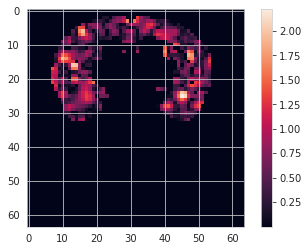

In [29]:
t = 400

plt.imshow(np.abs(func_CH_n[config.get_key(6, 1, 1)])[34, :, :, t])
plt.colorbar()

#### Put into df

In [30]:
dict_list = []
for key, x in func_CH_n.items():
    nt = x.shape[-1]
    for region_id, mask in roi_masks_inv.items():
        subject, session, run = config.looper[key]
        data_dict = {
            'bold': x[mask.numpy().astype(bool), :].mean(0),
            'timepoint': range(nt*(run-1), nt*run),
            'region_id': [region_id] * nt,
            'subject': [subject] * nt,
            'session': [session] * nt,
            'run': [run] * nt,
        }
        dict_list.append(data_dict)
df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [31]:
df

bold  timepoint region_id  subject  session  run
0      -0.032456          0     0-477        6        1    1
1      -0.105158          1     0-477        6        1    1
2      -0.103760          2     0-477        6        1    1
3      -0.029732          3     0-477        6        1    1
4      -0.031818          4     0-477        6        1    1
...          ...        ...       ...      ...      ...  ...
109195 -0.046709       4195  1-315-16        6        1    7
109196  0.122812       4196  1-315-16        6        1    7
109197  0.130745       4197  1-315-16        6        1    7
109198 -0.187302       4198  1-315-16        6        1    7
109199 -0.576766       4199  1-315-16        6        1    7

[109200 rows x 6 columns]

In [32]:
df_table = {}

for key, (subject, session, run) in config.looper.items():
    selected_df = df.loc[
        (df.subject == subject) &
        (df.session == session) &
        (df.run == run)
    ]
    if len(selected_df):
        df_table[key] = df.pivot(index='timepoint', columns='region_id', values='bold')
        
node_labels = list(df_table.values())[0].columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

In [33]:
df_table.keys()

dict_keys(['sub-SLC06_ses-1_run-1', 'sub-SLC06_ses-1_run-2', 'sub-SLC06_ses-1_run-3', 'sub-SLC06_ses-1_run-4', 'sub-SLC06_ses-1_run-5', 'sub-SLC06_ses-1_run-6', 'sub-SLC06_ses-1_run-7'])

In [34]:
df_table[config.get_key(6, 1, 1)]

region_id    0-1089   0-315-1   0-315-2   0-315-3   0-315-4   0-315-5  \
timepoint                                                               
0         -0.030049  0.148359  0.051286  0.243040  0.368150 -0.065703   
1         -0.204452  0.456234  0.189778  0.809569  1.181151 -0.088390   
2         -0.378004  0.663605  0.432005  0.958808  1.526218 -0.091289   
3         -0.332264  0.572034  0.747444  0.644919  1.209167 -0.378509   
4         -0.235435  0.356836  0.777564  0.626577  0.796962 -0.632196   
...             ...       ...       ...       ...       ...       ...   
4195       0.128290  0.729022  0.259729  0.427425 -0.295917 -0.135674   
4196       0.010580 -0.056719 -0.010686  0.959112 -0.350229 -0.432262   
4197      -0.115921 -0.564353 -0.062901  0.363205 -0.067406 -0.579292   
4198       0.108106 -0.523345 -0.194621 -0.626183 -0.158000 -0.818942   
4199       0.338635 -0.483704 -0.325980 -0.590897 -0.413675 -1.110130   

region_id   0-315-6   0-315-7   0-315-8     0-477  ...  1-315-12  1-315-13  \
timepoint                                          ...                       
0         -0.118334  0.109946  0.119660 -0.032456  ...  0.459392  0.000794   
1         -0.555511  0.436858  0.210284 -0.105158  ...  1.709421  0.149911   
2         -0.728260  0.816186  0.081727 -0.103760  ...  2.382273  0.413704   
3         -0.477625  0.633681  0.089338 -0.029732  ...  1.652623  0.264436   
4         -0.432709  0.083023  0.316010 -0.031818  ...  0.855378 -0.221346   
...             ...       ...       ...       ...  ...       ...       ...   
4195      -0.319180 -0.936927 -1.376593  0.015560  ... -0.460517 -0.328086   
4196      -0.377141 -0.924288 -1.491318  0.026394  ... -0.148122 -0.711346   
4197      -0.339665 -0.346422 -0.480476 -0.090201  ...  0.041307 -0.534908   
4198      -0.552004 -0.029806 -0.470850 -0.138502  ... -0.164021 -0.027729   
4199      -0.417389  0.184109 -1.115157 -0.050972  ... -0.422003  0.270049   

region_id  1-315-14  1-315-15  1-315-16   1-315-9     1-477     1-698  \
timepoint                                                               
0         -0.179611 -0.008179  0.058031 -0.026173 -0.019406  0.010064   
1         -0.672492 -0.141083 -0.283224 -0.201596 -0.042366 -0.001431   
2         -0.807940 -0.431626 -0.856273 -0.394375 -0.071523 -0.054094   
3         -0.277098 -0.561092 -0.799740 -0.211948 -0.113652 -0.105047   
4          0.179161 -0.469058 -0.186407 -0.084636 -0.100055 -0.088841   
...             ...       ...       ...       ...       ...       ...   
4195       0.063538 -0.084947 -0.046709 -0.098939 -0.097250 -0.138613   
4196       0.050203 -0.038584  0.122812  0.512188 -0.042230 -0.044815   
4197       0.191730 -0.085009  0.130745  0.597473 -0.063051  0.080431   
4198       0.085268 -0.021833 -0.187302 -0.086440 -0.152561  0.134013   
4199      -0.321499  0.182753 -0.576766 -0.457674 -0.124593  0.097840   

region_id     1-703     1-803  
timepoint                      
0          0.078464 -0.003329  
1          0.185474 -0.056656  
2          0.116681 -0.179273  
3         -0.013888 -0.251585  
4          0.054500 -0.200739  
...             ...       ...  
4195      -0.204007 -0.314001  
4196       0.037206 -0.180438  
4197       0.169498 -0.031980  
4198       0.078891  0.025705  
4199       0.003163  0.085176  

[4200 rows x 26 columns]

In [35]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [36]:
percentiles = [30, 25, 20, 18, 15, 10]
corrs = get_corrs(df_table[config.get_key(6, 1, 1)], percentiles=percentiles, positive_only=False)

In [37]:
corrs.keys()

dict_keys(['percentiles', 'pearson_thresholds', 'spearman_thresholds', 'pearson', 'spearman', 'pearson_corr', 'spearman_corr'])

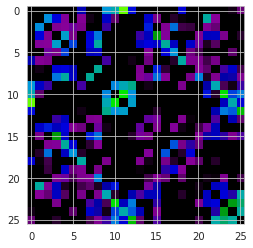

In [38]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral', vmin=0, vmax=1)

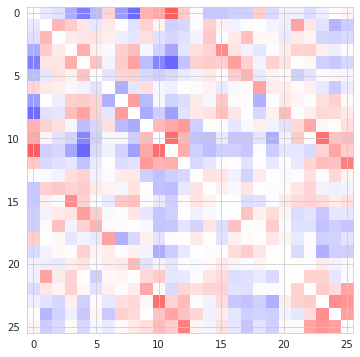

In [39]:
plt.figure(figsize=(8, 6))
plt.imshow(corrs['pearson_corr'], cmap='bwr', vmin=-1, vmax=1)

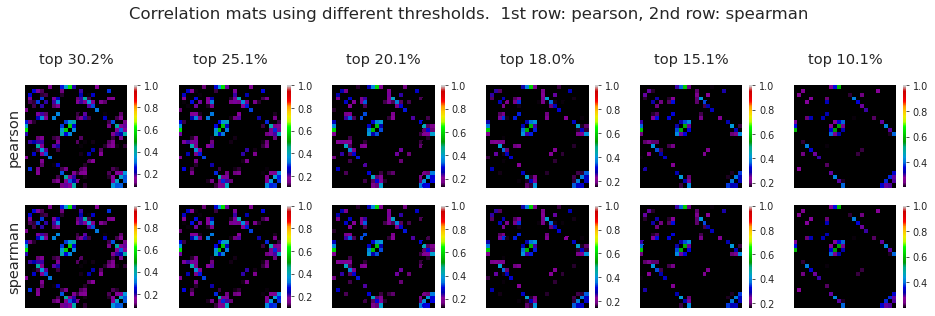

In [40]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

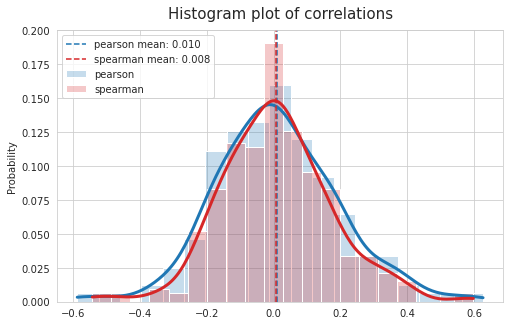

In [41]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=False,
    figsize=(8, 5),
)

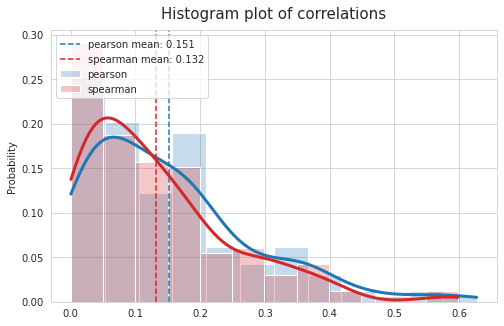

In [42]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=True,
    figsize=(8, 5),
)

## Hierarchical clustering

In [43]:
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy as sp_hier

In [44]:
x_dict = {
    k: np.array(list(v.values())).reshape(1, -1)
    for k, v in df_table[config.get_key(6, 1, 1)].to_dict().items()
}

In [45]:
x = np.concatenate(list(x_dict.values()))
y = pdist(X=x, metric='correlation')
z = sp_hier.linkage(y, method='ward', metric='euclidean', optimal_ordering=False)

x.shape, y.shape, z.shape

((26, 4200), (325,), (25, 4))

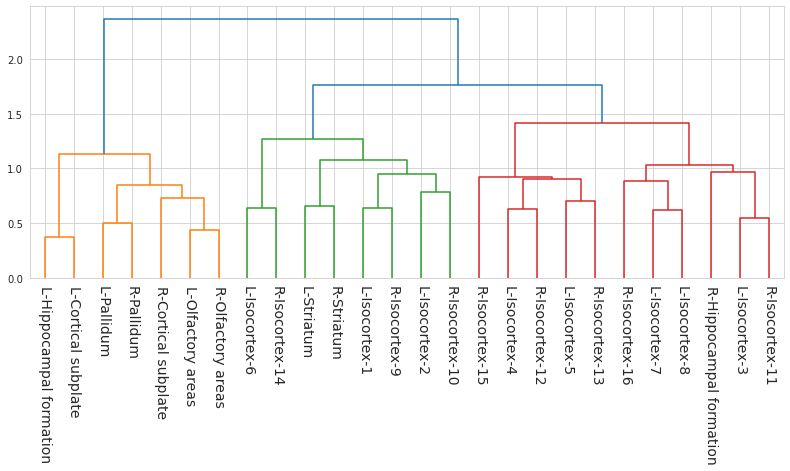

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(13.5, 5))

dn = sp_hier.dendrogram(
    Z=z,
    p=30,
    truncate_mode=None,
    color_threshold=None,
    get_leaves=True,
    orientation='top',
    labels=translate_labels(x_dict),
    count_sort=False,
    distance_sort=False,
    show_leaf_counts=True,
    no_plot=False,
    no_labels=False,
    leaf_font_size=14,
    leaf_rotation=-90,
    leaf_label_func=None,
    show_contracted=False,
    link_color_func=None,
    ax=ax,
    above_threshold_color='C0',
)

In [47]:
partition = {node: color for node, color in zip(dn['leaves'], dn['leaves_color_list'])}
color2idx = {c: i+1 for i, c in enumerate(set(partition.values()))}

partition = {node: color2idx[c] for node, c in partition.items()}
partition = dict(sorted(partition.items()))
partition = {node_labels[node]: comm_idx for node, comm_idx in partition.items()}

In [48]:
comms3d = np.zeros(template.shape)
for label, comm_idx in partition.items():  
    if str(isocortex['id']) in label:
        lr, structure_id, region_id = tuple(map(lambda x: int(x), label.split('-')))
        comms3d[parcellation['atlas_kmeans'] == region_id] = comm_idx
    else:
        comms3d[roi_masks[label]] = comm_idx

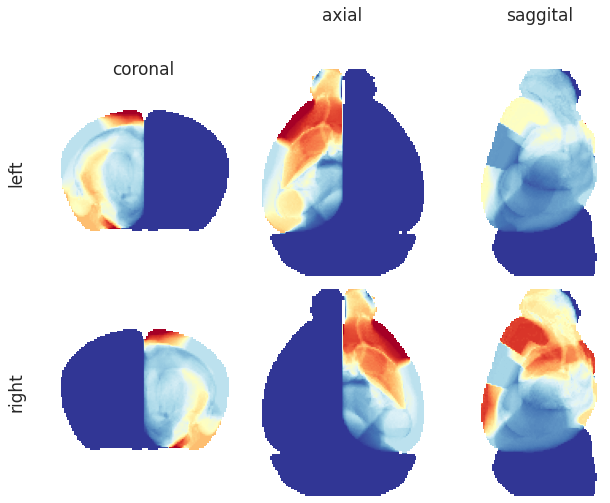

In [49]:
mask_l, mask_r = mask_left_right(root_mask)

_ = plot_parcellation(
    parcellation=comms3d,
    mask_l=mask_l,
    mask_r=mask_r,
    root_mask=root_mask,
    cmap='RdYlBu_r',
)

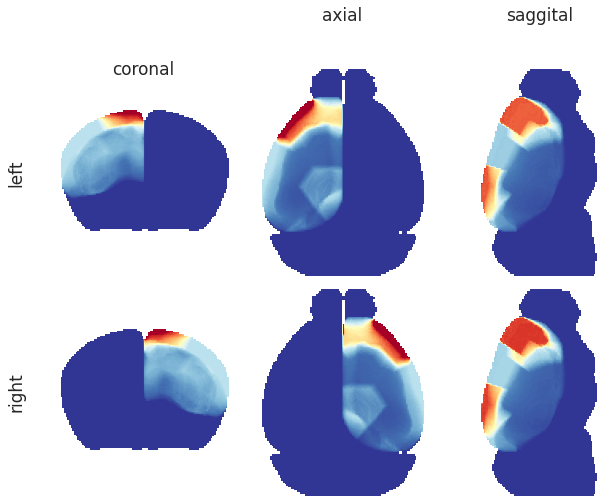

In [54]:
x = comms3d.copy()
x[~cortex_mask.astype(bool)] = 0

_ = plot_parcellation(
    parcellation=x,
    mask_l=parcellation['mask_l'],
    mask_r=parcellation['mask_r'],
    root_mask=root_mask,
    cmap='RdYlBu_r',
)

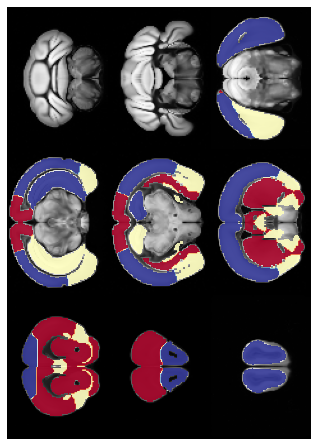

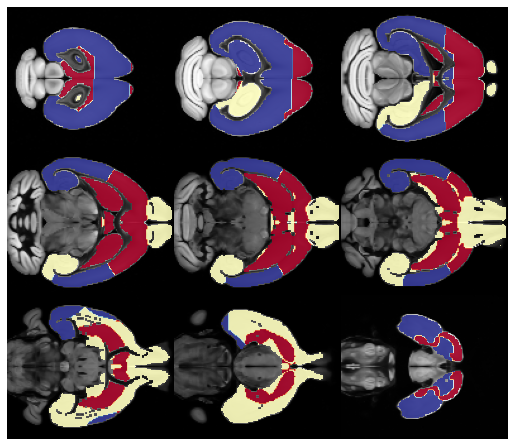

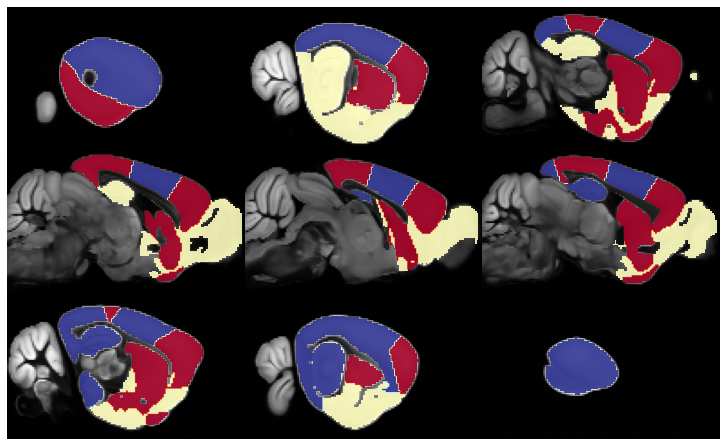

In [55]:
x = comms3d.copy()
x[~cerebrum_mask.astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=9,
        figsize=2,
        axis=axis,
    )

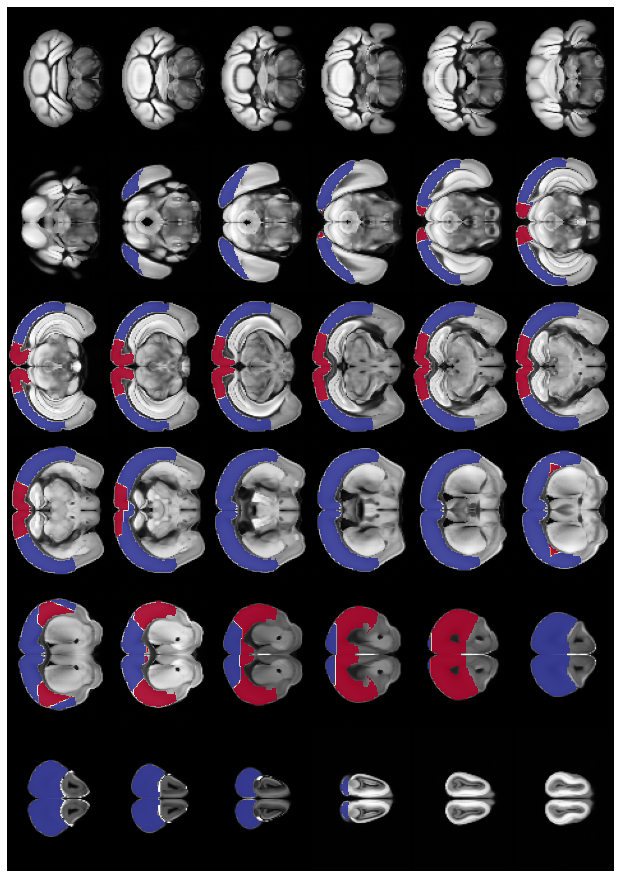

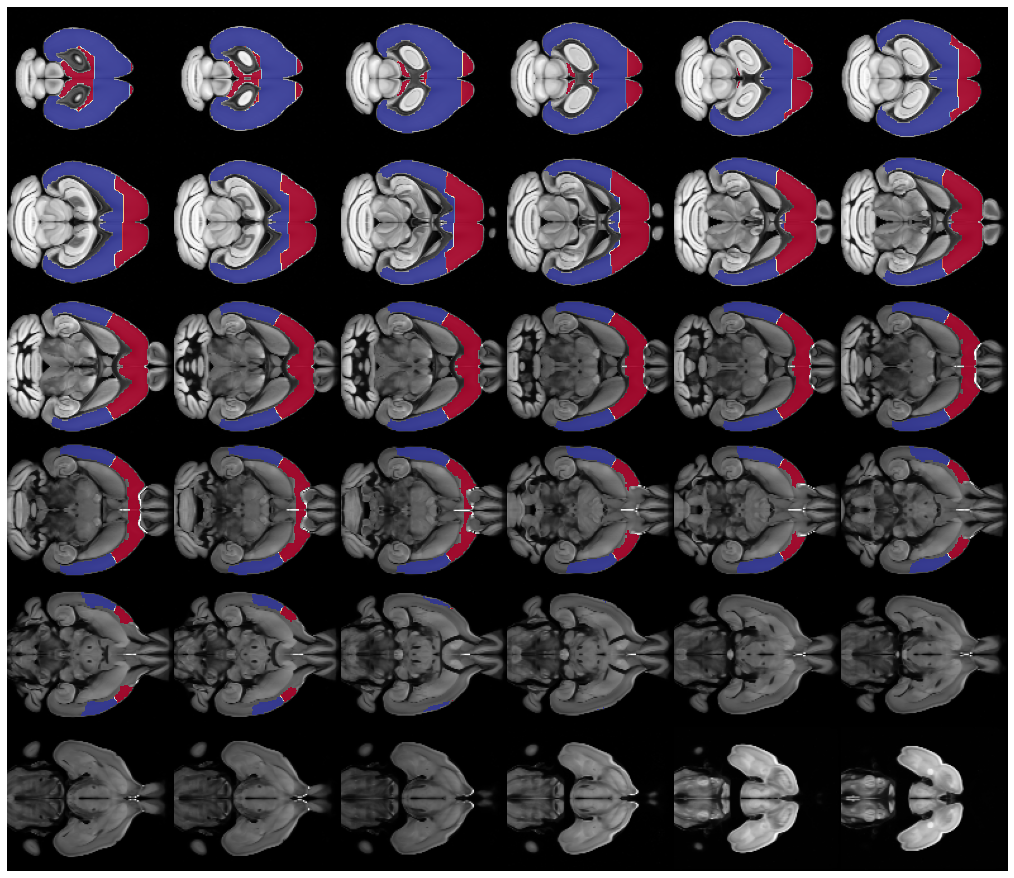

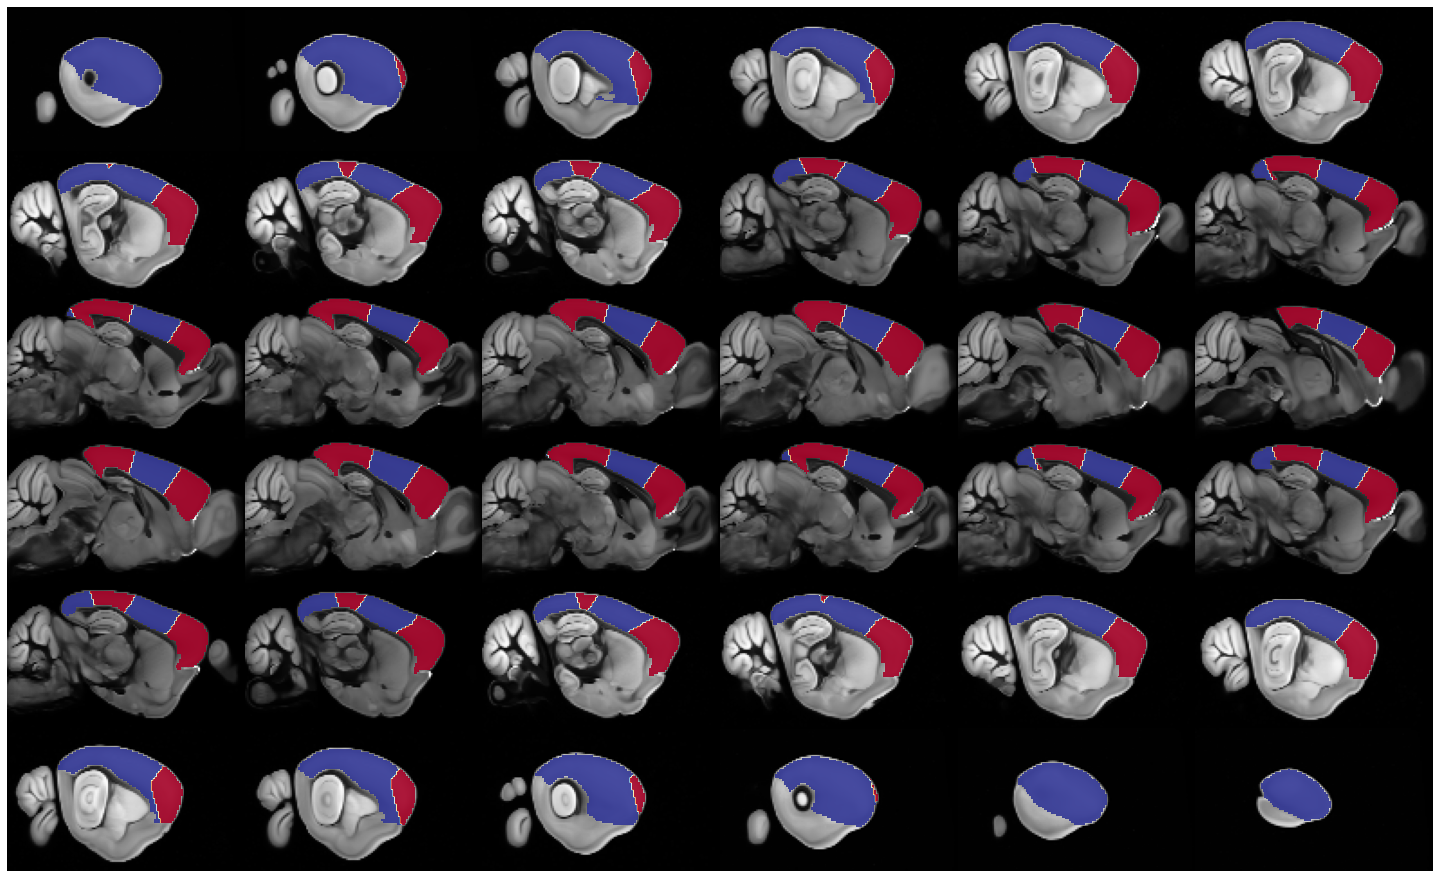

In [56]:
x = comms3d.copy()
x[~cortex_mask.astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=36,
        figsize=2,
        axis=axis,
    )

## Combine 3 sessions, subject 6

### Load anat

In [74]:
def reset_ants_img(img: Union[np.ndarray, ants.ANTsImage], dtype=float, origin=0, spacing=1.0):
    ndims = len(img.shape)
    if isinstance(img, ants.ANTsImage):
        img = img.numpy()
    return ants.from_numpy(img.astype(dtype), origin=[origin]*ndims, spacing=[spacing]*ndims)

In [75]:
fixed = reset_ants_img(template)

In [78]:
config = Config()

n_seeds = 5
seeds = [2**i for i in range(n_seeds)]

moving_imgs = {}
warped_imgs = {}
transforms = {}
for key, (subject, session, run) in tqdm(config.looper.items()):
    if subject != 6:
        continue

    if run != 1:
        continue

    keywords = key.split('_')[:2] + ['space-individual']

    # anat
    kws_anat = keywords + ['T1w']
    gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_anat))
    anat_file = pjoin(config.raw_dir, next(gen))

    # mask
    kws_mask = keywords + ['desc-mask', 'bold']
    gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_mask))
    mask_file = pjoin(config.raw_dir, next(gen))

    # load anat and mask and reorient
    moving = nib.load(anat_file).get_fdata()
    mask = nib.load(mask_file).get_fdata()
    moving *= mask

    moving = reorient_arr(moving)
    moving = reset_ants_img(moving)
    
    new_key = '_'.join(keywords[:2])
    moving_imgs[new_key] = moving
    
    _txs = []
    _perf = []
    for seed in seeds:
        tx = ants.registration(
            fixed=fixed,
            moving=moving,
            mask=moving.get_mask(),
            type_of_transform='SyN',
            verbose=True,
            random_seed=seed,
        )
        warped = ants.apply_transforms(
            fixed=fixed,
            moving=moving,
            transformlist=tx['fwdtransforms'],
            interpolator='linear',
        )
        mi = ants.image_mutual_information(fixed, warped)
        mi_base = ants.image_mutual_information(fixed, fixed)

        _txs.append(tx)
        _perf.append(mi/mi_base)
        
        # print(new_key, seed, mi/mi_base)
        
    best_tx = _txs[np.argmax(_perf)]
    transforms[new_key] = best_tx
    
    warped = ants.apply_transforms(
        fixed=fixed,
        moving=moving,
        transformlist=best_tx['fwdtransforms'],
        interpolator='linear',
    )
    warped_imgs[new_key] = warped
    
    mi = ants.image_mutual_information(fixed, warped)
    mi_base = ants.image_mutual_information(fixed, fixed)
    print('{:s},\tbest rel mi: {:.3f}'.format(key, mi/mi_base))

  0%|          | 0/210 [00:00<?, ?it/s]

sub-SLC06_ses-1_run-1,	best rel mi: 0.450
sub-SLC06_ses-2_run-1,	best rel mi: 0.428
sub-SLC06_ses-3_run-1,	best rel mi: 0.447


#### Viz registeration

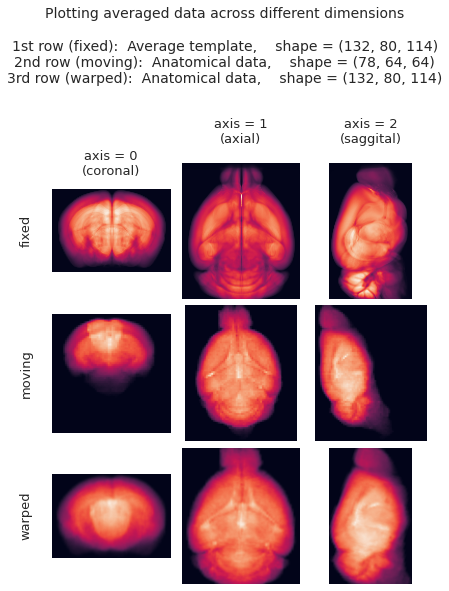

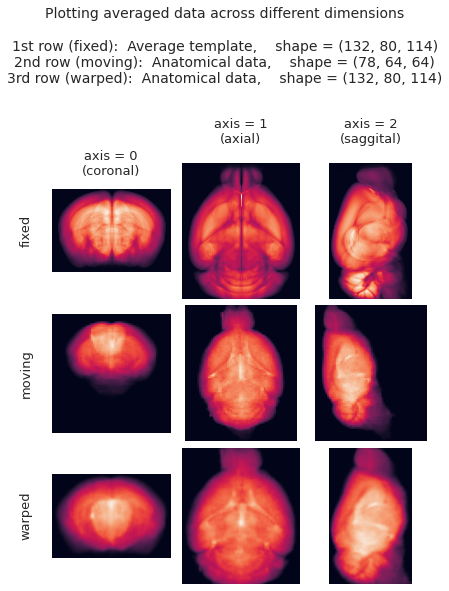

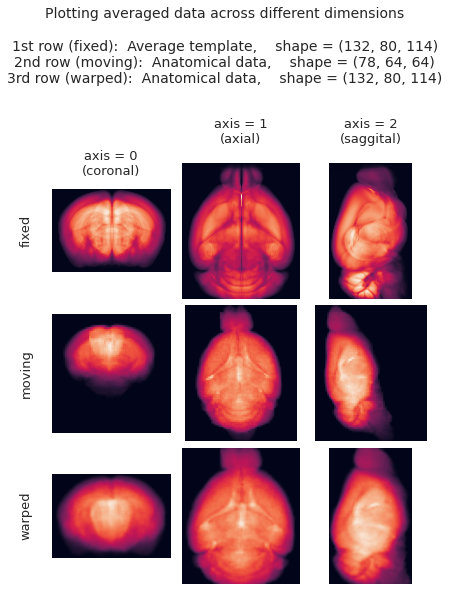

In [79]:
for k, moving in moving_imgs.items():
    _ = plot_registration(fixed, moving, warped_imgs[k])

### Inv mask transforms

In [80]:
masks_inv = {}
for key, best_tx in transforms.items():
    inv = {}
    inv['roi'] = {
        lbl: ants.apply_transforms(
            fixed=moving,
            moving=reset_ants_img(mask),
            transformlist=best_tx['invtransforms'],
            interpolator='genericLabel', )
        for lbl, mask in roi_masks.items()
    }
    _masks = [parcellation['mask_l'], parcellation['mask_r'], root_mask, cerebrum_mask, cortex_mask]
    left_inv, right_inv, root_inv, cerebrum_inv, cortex_inv = [
        ants.apply_transforms(
            fixed=moving,
            moving=reset_ants_img(mask),
            transformlist=best_tx['invtransforms'],
            interpolator='genericLabel', )
        for mask in _masks
    ]
    inv['left'] = left_inv
    inv['right'] = right_inv
    inv['root'] = root_inv
    inv['cerebrum'] = cerebrum_inv
    inv['cortex'] = cortex_inv
    
    masks_inv[key] = inv

In [93]:
atlas_inv = {}
for key, val in masks_inv.items():
    atlas_kmeans_inv = np.zeros(moving.shape)
    for lbl, mask_inv in val['roi'].items():
        if str(isocortex['id']) not in lbl:
            continue
        region_id = int(lbl.split('-')[-1])
        atlas_kmeans_inv[mask_inv.numpy().astype(bool)] = region_id
    atlas_inv[key] = atlas_kmeans_inv

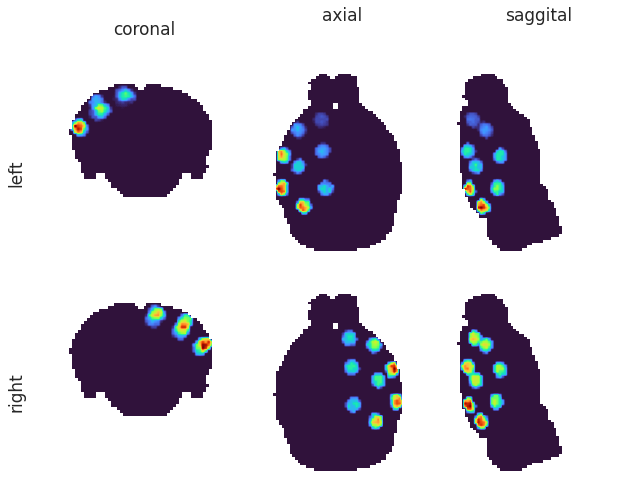

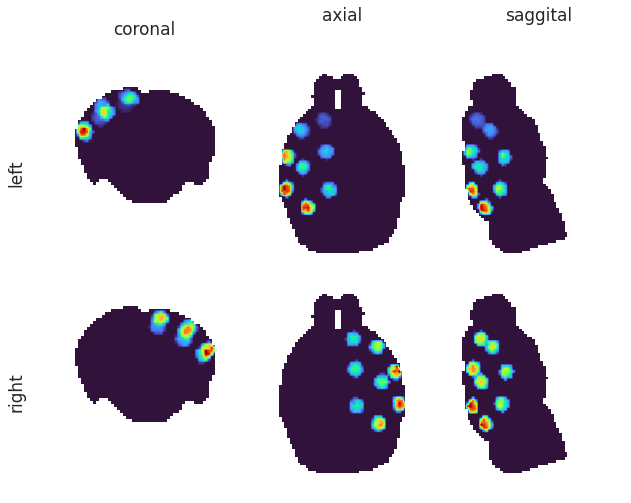

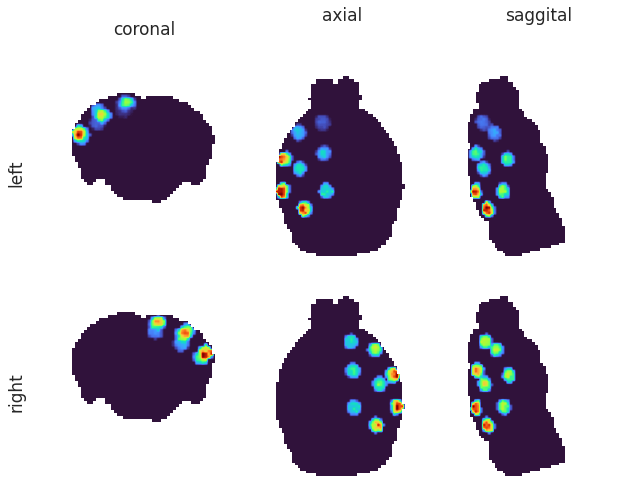

In [96]:
for key, atlas_kmeans_inv in atlas_inv.items():
    _ = plot_parcellation(
        parcellation=atlas_kmeans_inv,
        mask_l=masks_inv[key]['left'].numpy().astype(bool),
        mask_r=masks_inv[key]['right'].numpy().astype(bool),
        root_mask=masks_inv[key]['root'].numpy().astype(bool),
    )

### Load func

In [119]:
config = Config()

func_imgs = {}
for key, (subject, session, run) in tqdm(config.looper.items()):
    if subject != 6:
        continue

    keywords = key.split('_')[:2] + ['space-individual']

    # func
    kws_func = keywords + ['run-{:d}'.format(run), 'bold']
    gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_func))
    try:
        func_file = pjoin(config.raw_dir, next(gen))
    except StopIteration:
        continue
    x = nib.load(func_file).get_fdata()
    func_imgs[key] = reorient_arr(x)

  0%|          | 0/210 [00:00<?, ?it/s]

#### Combine func data

In [ ]:
func_CH = {
    k: v * np.expand_dims(masks_inv['_'.join(k.split('_')[:2])]['cerebrum'].numpy().astype(bool), axis=-1)
    for k, v in func_imgs.items()
}
mean_sd = {
    k: (v[masks_inv['_'.join(k.split('_')[:2])]['cerebrum'].numpy().astype(bool), :].mean(),
        v[masks_inv['_'.join(k.split('_')[:2])]['cerebrum'].numpy().astype(bool), :].std())
 for k, v in func_CH.items()
}
func_CH_n = {k: (func_CH[k] - mean) / sd for k, (mean, sd) in mean_sd.items()}

In [ ]:
{k: (
    np.round(v[masks_inv['_'.join(k.split('_')[:2])]['cerebrum'].numpy().astype(bool), :].mean(), decimals=7),
    np.round(v[masks_inv['_'.join(k.split('_')[:2])]['cerebrum'].numpy().astype(bool), :].std(), decimals=7),
) for k, v in func_CH_n.items()}

In [ ]:
{k: v.shape for k, v in func_CH_n.items()}

In [ ]:
t = 400

plt.imshow(np.abs(func_CH_n[config.get_key(6, 1, 1)])[34, :, :, t])
plt.colorbar()

#### Put into df

In [112]:
dict_list = []
for key, x in func_CH_n.items():
    nt = x.shape[-1]
    for region_id, mask in roi_masks_inv.items():
        subject, session, run = config.looper[key]
        data_dict = {
            'bold': x[mask.numpy().astype(bool), :].mean(0),
            'timepoint': range(nt*(run-1), nt*run),
            'region_id': [region_id] * nt,
            'subject': [subject] * nt,
            'session': [session] * nt,
            'run': [run] * nt,
        }
        dict_list.append(data_dict)
df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [113]:
df

bold  timepoint region_id  subject  session  run
0      -0.031959          0     0-477        6        1    1
1      -0.104037          1     0-477        6        1    1
2      -0.102623          2     0-477        6        1    1
3      -0.028623          3     0-477        6        1    1
4      -0.030711          4     0-477        6        1    1
...          ...        ...       ...      ...      ...  ...
109195 -0.046690       4195  1-315-16        6        1    7
109196  0.122764       4196  1-315-16        6        1    7
109197  0.130694       4197  1-315-16        6        1    7
109198 -0.187229       4198  1-315-16        6        1    7
109199 -0.576541       4199  1-315-16        6        1    7

[109200 rows x 6 columns]

In [114]:
df_table = {}

for key, (subject, session, run) in config.looper.items():
    selected_df = df.loc[
        (df.subject == subject) &
        (df.session == session) &
        (df.run == run)
    ]
    if len(selected_df):
        df_table[key] = df.pivot(index='timepoint', columns='region_id', values='bold')
        
node_labels = list(df_table.values())[0].columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

In [115]:
df_table.keys()

dict_keys(['sub-SLC06_ses-1_run-1', 'sub-SLC06_ses-1_run-2', 'sub-SLC06_ses-1_run-3', 'sub-SLC06_ses-1_run-4', 'sub-SLC06_ses-1_run-5', 'sub-SLC06_ses-1_run-6', 'sub-SLC06_ses-1_run-7'])

In [ ]:
df_table[config.get_key(6, 1, 1)]

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
percentiles = [30, 25, 20, 18, 15, 10]
corrs = get_corrs(df_table[config.get_key(6, 1, 1)], percentiles=percentiles, positive_only=False)

In [37]:
corrs.keys()

dict_keys(['percentiles', 'pearson_thresholds', 'spearman_thresholds', 'pearson', 'spearman', 'pearson_corr', 'spearman_corr'])

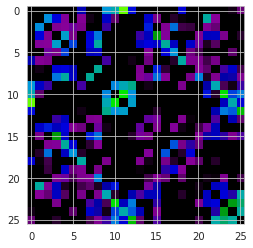

In [38]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral', vmin=0, vmax=1)

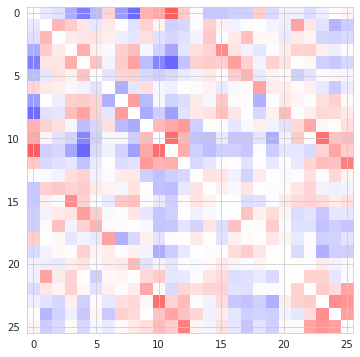

In [39]:
plt.figure(figsize=(8, 6))
plt.imshow(corrs['pearson_corr'], cmap='bwr', vmin=-1, vmax=1)

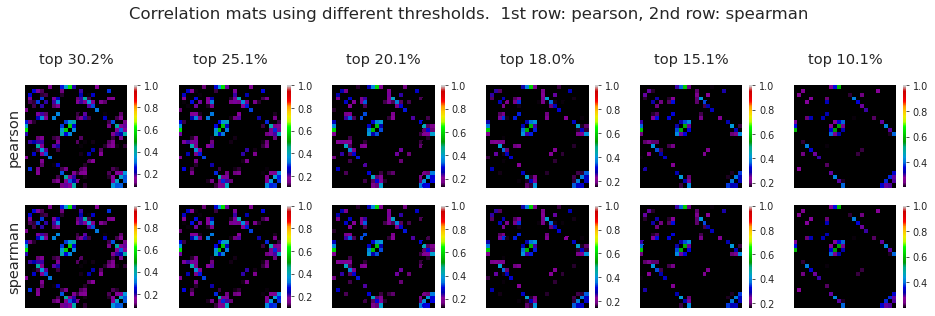

In [40]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

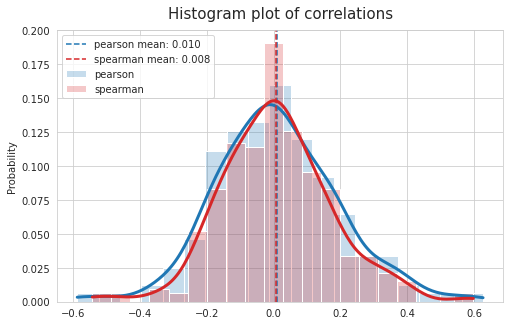

In [41]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=False,
    figsize=(8, 5),
)

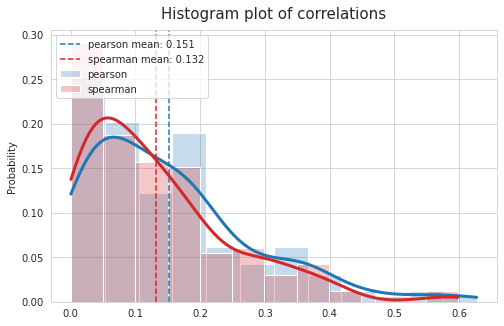

In [42]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=True,
    figsize=(8, 5),
)

## Hierarchical clustering

In [43]:
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy as sp_hier

In [44]:
x_dict = {
    k: np.array(list(v.values())).reshape(1, -1)
    for k, v in df_table[config.get_key(6, 1, 1)].to_dict().items()
}

In [45]:
x = np.concatenate(list(x_dict.values()))
y = pdist(X=x, metric='correlation')
z = sp_hier.linkage(y, method='ward', metric='euclidean', optimal_ordering=False)

x.shape, y.shape, z.shape

((26, 4200), (325,), (25, 4))

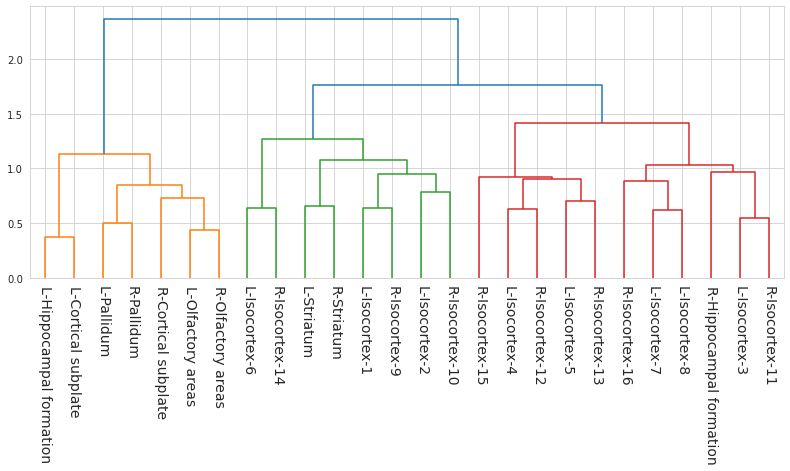

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(13.5, 5))

dn = sp_hier.dendrogram(
    Z=z,
    p=30,
    truncate_mode=None,
    color_threshold=None,
    get_leaves=True,
    orientation='top',
    labels=translate_labels(x_dict),
    count_sort=False,
    distance_sort=False,
    show_leaf_counts=True,
    no_plot=False,
    no_labels=False,
    leaf_font_size=14,
    leaf_rotation=-90,
    leaf_label_func=None,
    show_contracted=False,
    link_color_func=None,
    ax=ax,
    above_threshold_color='C0',
)

In [47]:
partition = {node: color for node, color in zip(dn['leaves'], dn['leaves_color_list'])}
color2idx = {c: i+1 for i, c in enumerate(set(partition.values()))}

partition = {node: color2idx[c] for node, c in partition.items()}
partition = dict(sorted(partition.items()))
partition = {node_labels[node]: comm_idx for node, comm_idx in partition.items()}

In [48]:
comms3d = np.zeros(template.shape)
for label, comm_idx in partition.items():  
    if str(isocortex['id']) in label:
        lr, structure_id, region_id = tuple(map(lambda x: int(x), label.split('-')))
        comms3d[parcellation['atlas_kmeans'] == region_id] = comm_idx
    else:
        comms3d[roi_masks[label]] = comm_idx

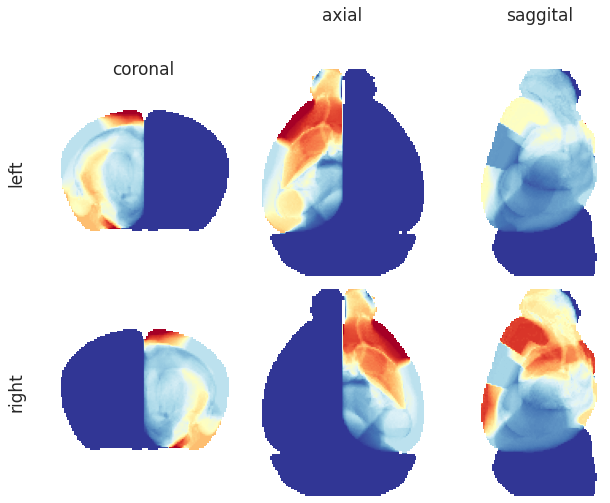

In [49]:
mask_l, mask_r = mask_left_right(root_mask)

_ = plot_parcellation(
    parcellation=comms3d,
    mask_l=mask_l,
    mask_r=mask_r,
    root_mask=root_mask,
    cmap='RdYlBu_r',
)

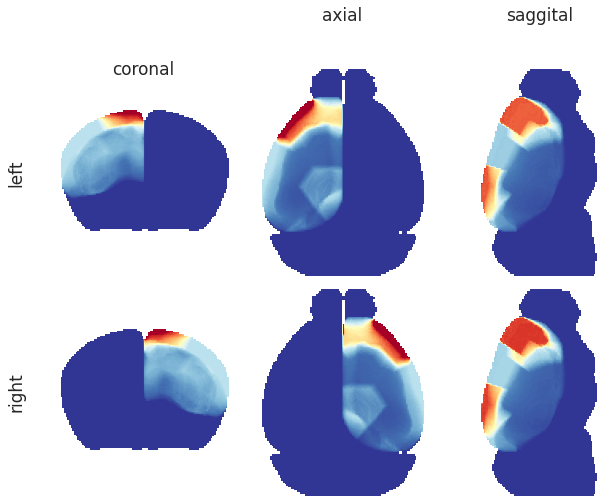

In [54]:
x = comms3d.copy()
x[~cortex_mask.astype(bool)] = 0

_ = plot_parcellation(
    parcellation=x,
    mask_l=parcellation['mask_l'],
    mask_r=parcellation['mask_r'],
    root_mask=root_mask,
    cmap='RdYlBu_r',
)

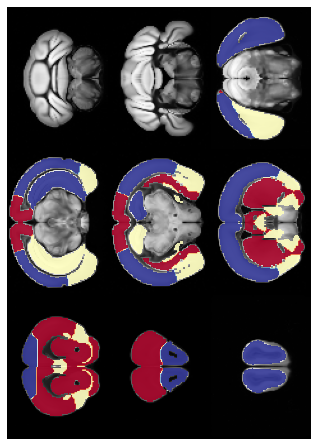

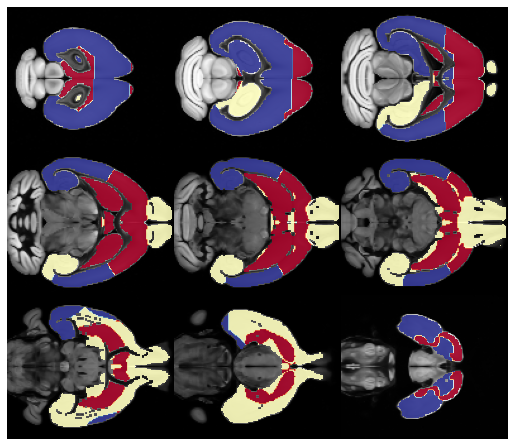

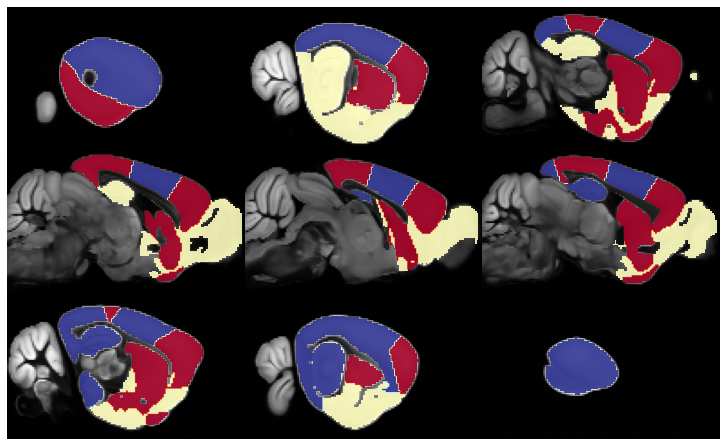

In [55]:
x = comms3d.copy()
x[~cerebrum_mask.astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=9,
        figsize=2,
        axis=axis,
    )

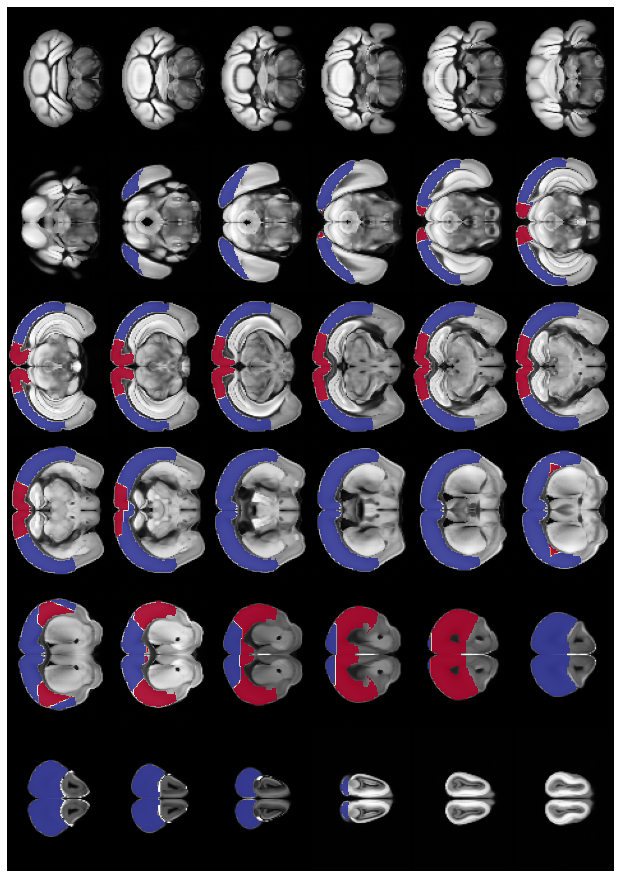

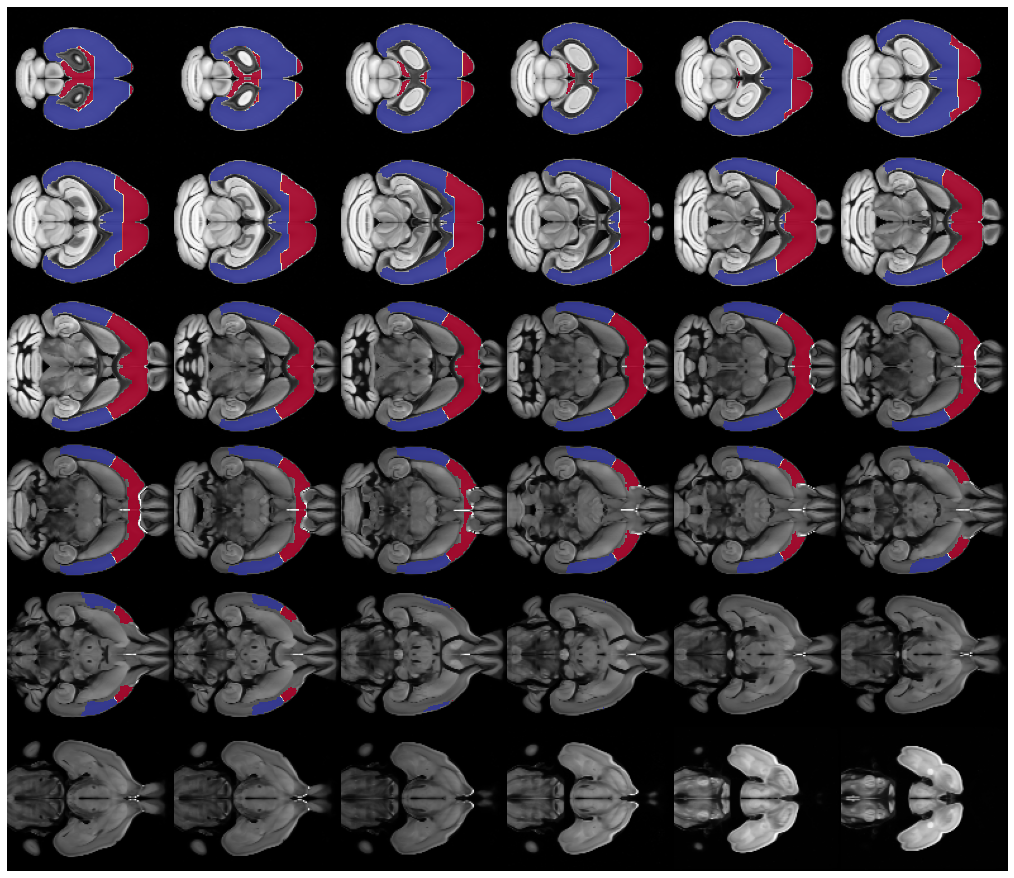

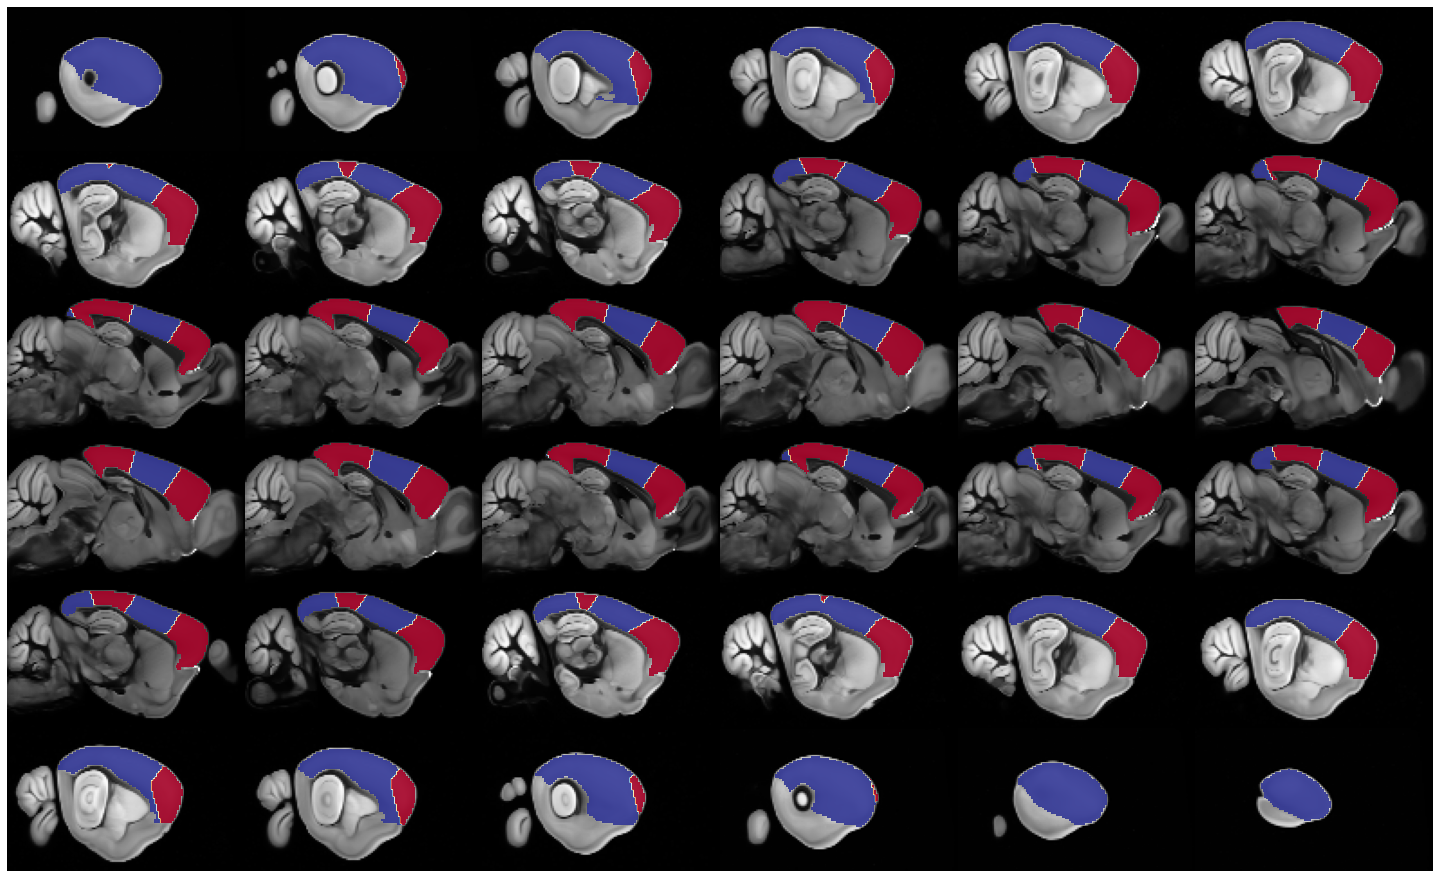

In [56]:
x = comms3d.copy()
x[~cortex_mask.astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=36,
        figsize=2,
        axis=axis,
    )